import clasic libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import linprog
from matplotlib import colors


import python scripts and imporlib

In [3]:
import importlib
import src  # python scripts

import files, functions, classes

In [5]:
from src.UpscaleMatrix import upscale_matrix
#from py_scripts.TissueIrradiationProblem import TissueIrradiationProblem
#from py_scripts.TissueIrradiationOptimizer import TissueIrradiationOptimizer
from src import TissueIrradiationProblem, TissueIrradiationOptimizer


Upscale matrix use example

In [7]:
# Example usage of upscale_matrix

#upscale_matrix(2, 3) -> 3x3 matrix of 2s
matrix = np.array([[1, 2], [3, 4]])
print(f"Matrix:\n{matrix}")
matrix_upscaled = upscale_matrix(matrix, 2)
print("Upscaled Matrix:\n", matrix_upscaled)


Matrix:
[[1 2]
 [3 4]]
Upscaled Matrix:
 [[1 1 2 2]
 [1 1 2 2]
 [3 3 4 4]
 [3 3 4 4]]


## Import SITCF coefficients
 - SITCF - Simulated Irradiation Tissue Cells Factors
 * I use shoret abbrv: **SIF = Simulation Irradiation Factors**
 - simulation based dose distrribution

In [74]:
# import npy file from the folder
fp = "../../SIF_coefficients/SIF_mono_20cm_7pixels_120kev_1e+04photons.npy"
SIF_data = np.load(fp)
### SIF = Simulation Irradioation Factors

In [75]:
print(SIF_data[9])
print("\n")
#print(SIF_data[8])

[[0.0226136  0.03385329 0.0452056  0.05880323 0.05869655 0.07216311
  0.05757568]
 [0.02687145 0.04988433 0.07039498 0.10002418 0.12792419 0.12426324
  0.11212666]
 [0.08892072 0.14940205 0.20460149 0.3259127  0.45726172 0.69121386
  1.        ]
 [0.04455723 0.06329984 0.07247121 0.08938662 0.13471996 0.14260581
  0.10828204]
 [0.02700194 0.04268868 0.06491818 0.07220144 0.06906373 0.07283568
  0.05342649]
 [0.01889808 0.03455634 0.04180091 0.03946507 0.04875242 0.04148522
  0.03086169]
 [0.01202783 0.02230481 0.0206552  0.02853271 0.02655898 0.02612229
  0.02325861]]




---
---
# Optimize Irradiation plan

---
### 1. define Tissue Matrix

Plotting tissue matrix...


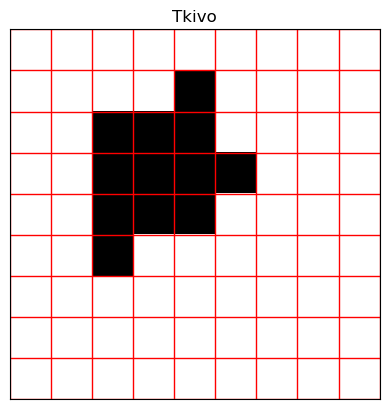

In [215]:
# test the class
tissue_matrix_5by5 = np.array([[0, 0, 0, 0, 0],
                           [0, 0, 1, 0, 0],   
                           [0, 1, 1, 1, 0],
                           [0, 1, 1, 0, 0],
                           [0, 0, 0, 0, 0]])

tissue_matrix_3by3 = np.array([[0, 0, 0,],
                           [0, 1, 0],
                           [0,1,1]])

tissue_matrix_2by2 =  np.array([[0, 0],
                               [1, 0]])

tissue_matrix_9by9 = np.array([[0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 1, 0, 0, 0, 0],
                               [0, 0, 1, 1, 1, 0, 0, 0, 0],
                               [0, 0, 1, 1, 1, 1, 0, 0, 0],
                               [0, 0, 1, 1, 1, 0, 0, 0, 0],
                               [0, 0, 1, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0, 0, 0]])

tissue_matrix_7by7 = np.array([[0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 1, 0, 0],
                               [0, 0, 1, 1, 1, 0, 0],
                               [0, 0, 1, 1, 1, 1, 0],
                               [0, 0, 0, 1, 1, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0],
                               [0, 0, 0, 0, 0, 0, 0]])

#* choose one of the matrices above
tissue_matrix = tissue_matrix_9by9 

#* upscale matrix (optional, for testing lin. prog. capabilities...)
upscale_factor = 1
if upscale_factor > 1:
    tissue_matrix = upscale_matrix(tissue_matrix, upscale_factor)

importlib.reload(TissueIrradiationProblem)
# create a problem instance
problem = TissueIrradiationProblem.tissue_irradiation_problem(tissue_matrix)
#* plot the tissue matrix
# 1 = tumor = black
# 0 = healthy = white
problem.plot_tissue()

# cmap = colors.LinearSegmentedColormap.from_list('custom_bw', ['white', 'black'])
# plt.imshow(tissue_matrix, cmap=cmap, interpolation='nearest')
# plt.title('Tissue Matrix')
# plt.xticks([])
# plt.yticks([])
# plt.show()

---
### 2. define optimization parameters

* dose constraints to tumor and optionally healthy cells


In [216]:
# dose constraints to tumor and optionally healthy cells
MinDoseTumor = 100  # minimum dose to tumor cells

MaxDoseHealthy = None # maximum dose to healthy cells (optional, can be None, can cause optimization issues!)

cell_dose_constr = {
    'min_dose_tumor': MinDoseTumor,
    'max_dose_healthy': MaxDoseHealthy
}

* mean free paths of photons - energy dependance

At 10.0 keV, total linear attenuation coefficient is 6.5882 /cm; (mean free path = 0.1518 cm)
At 20.0 keV, total linear attenuation coefficient is 0.9412 /cm; (mean free path = 1.0625 cm)
At 35.0 keV, total linear attenuation coefficient is 0.3388 /cm; (mean free path = 2.9517 cm)
At 25.0 keV, total linear attenuation coefficient is 0.6715 /cm; (mean free path = 1.4892 cm)
At 50.0 keV, total linear attenuation coefficient is 0.2303 /cm; (mean free path = 4.3426 cm)
At 80.0 keV, total linear attenuation coefficient is 0.1871 /cm; (mean free path = 5.3437 cm)
At 100.0 keV, total linear attenuation coefficient is 0.1751 /cm; (mean free path = 5.7106 cm)
At 250.0 keV, total linear attenuation coefficient is 0.1333 /cm; (mean free path = 7.5030 cm)
At 500.0 keV, total linear attenuation coefficient is 0.1015 /cm; (mean free path = 9.8537 cm)
At 1000.0 keV, total linear attenuation coefficient is 0.0742 /cm; (mean free path = 13.4798 cm)


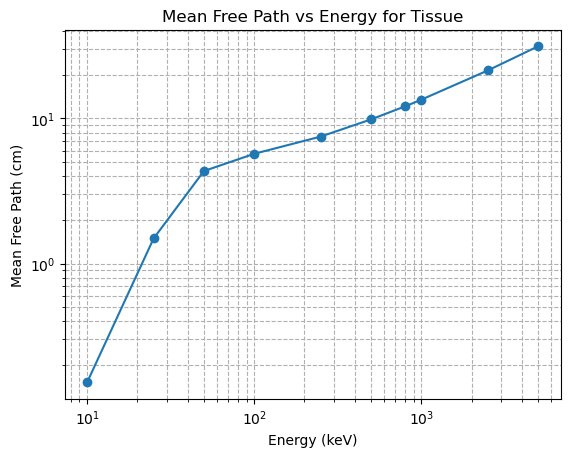

In [209]:
from src import LinearAttenuationCoefficients as LACload
path = "../mac_nistxcom/mac_tissue.txt"
tissue_density = 1.06  # g/cm^3
tissue_lac_importer = LACload.LACLoader(path, tissue_density, material_name="Tissue")

energies = [0.01,0.02,0.035,0.025,0.05,0.08,0.1,0.25,0.5,1.0] # MeV

for energy in energies:
    lac_value = tissue_lac_importer.get_lac_at_energy(energy)
    print(f"At {energy*1000} keV, total linear attenuation coefficient is {lac_value:.4f} /cm"
          f"; (mean free path = {1/lac_value:.4f} cm)"
          )
    
###!!!! ADD THIS TO CLASS DEFINITION !!!!####
# make a plot - LAC(energy) or MFP(energy) [mean free path]
energy_pts = np.array([0.01, 0.025,0.05,0.1,0.25,0.5, 0.8,1.0,2.5,5]) 
lac_pts = np.array([tissue_lac_importer.get_lac_at_energy(energy) for energy in energy_pts])
mfp_pts = 1/lac_pts
#plt.plot(energy_pts, lac_pts, marker='o', label='LAC')
plt.plot(energy_pts*1000, mfp_pts, marker='o', label='MFP')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Energy (keV)')
#plt.ylabel('Linear Attenuation Coefficient (/cm)')
plt.ylabel('Mean Free Path (cm)')
#plt.title('Linear Attenuation Coefficient vs Energy for Tissue')
plt.title('Mean Free Path vs Energy for Tissue')
plt.grid(True, which="both", ls="--")

* define beam type

In [217]:
 #* choose beam type: 'constant', 'exponential', or 'simulated'
beam_type = ['constant','exponential','simulated'][2]  

print(f"---------------Beam type chosen: {beam_type}-------------------")

#* check if simulated beam type dimensions are correct
if beam_type == 'simulated':
    # number of rows/columns in the simulated tissue matrix
    tissue_dimension_simulated = SIF_data.shape[0] // 4  
    if tissue_dimension_simulated == tissue_matrix.shape[0]:
        print("Tissue shape for 'simulated' beam type is correct.")
    else:
        raise ValueError("Tissue shape for 'simulated' beam type should be" \
                          f"{tissue_dimension_simulated}x{tissue_dimension_simulated}; " \
                          f"but got {tissue_matrix.shape[0]}x{tissue_matrix.shape[1]}.")

---------------Beam type chosen: simulated-------------------


ValueError: Tissue shape for 'simulated' beam type should be7x7; but got 9x9.

* parameters of exponential and simulated beams
    - exponential - mean free path
    - simulation - tissue length, num of pixels, beam type and energy, Nsim, SIF_data 

In [221]:
 
#$ exponential ...
# mfp in terms of cells, eg 2 cells, multiply by uscale_factor if supcaled matrix
#! shall approximately match real data! (use LACloader and calculated mean free paths!)
#!  -> compare to simulated beam type optimization
mean_free_path = 3 * upscale_factor
lac = 1.0 / mean_free_path  # linear attenuation coefficient in 1/cell

#$ handle simulated SITCF factors and mean free path ...
beam_idx = 0
beam_spectrum_type = ["mono", "rtg"][beam_idx]  # choose one of the two spectrum types
tissue_length = 24  # cm
num_pixels = 9  # number of pixels
Ebeam = [50, 6][beam_idx]  # photon energy in keV
Eunit = ["kev","MV"][beam_idx]
Ebeam_txt = f"{Ebeam}{Eunit}"
Nsim = "1e+03"
fp = f"../../SIF_coefficients/SIF_{beam_spectrum_type}_{tissue_length}cm_{num_pixels}pixels_{Ebeam_txt}_{Nsim}photons.npy"
print(f"Filepath to SIF data: {fp}")
SIF_data = np.load(fp)
if beam_type == 'simulated':
    # number of rows/columns in the simulated tissue matrix
    tissue_dimension_simulated = SIF_data.shape[0] // 4  
    if tissue_dimension_simulated == tissue_matrix.shape[0]:
        print("Tissue shape for 'simulated' beam type is correct.")
    else:
        raise ValueError("Tissue shape for 'simulated' beam type should be" \
                          f"{tissue_dimension_simulated}x{tissue_dimension_simulated}; " \
                          f"but got {tissue_matrix.shape[0]}x{tissue_matrix.shape[1]}.")



Filepath to SIF data: ../../SIF_coefficients/SIF_mono_24cm_9pixels_50kev_1e+03photons.npy
Tissue shape for 'simulated' beam type is correct.


In [222]:
# prepare data for linear programming

ProblemParameters = problem.prepare_data_for_linprog(
    cell_dose_constr,
    beam_type=beam_type, 
    lac=lac, 
    sim_irr_factors=SIF_data
    )

#ProblemParameters


Using beam from self simulated data for energy deposition distribution.
Linear programming inputs defined.


optimization time

In [223]:
# optimize class
importlib.reload(TissueIrradiationOptimizer)
optimizer = TissueIrradiationOptimizer.tissue_irradiation_optimizer(ProblemParameters)
# run optimization
report = [False, True] [1]
optimizer.optimize(doReport=report)

# calculate dose distribution
TissueDoseDistribution = optimizer.tissue_dose_matrix

#print(f"\nDose Distribution Matrix:\n{TissueDoseDistribution}")



Optimization successful.
Optimal value: 4085.181189304752
Optimal solution: [  0.           0.           0.          89.13078482 113.94562424
 211.37056792   0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.         279.98199801 460.31810828 106.51284088 111.04489859
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.
   0.        ]


plot and statistics

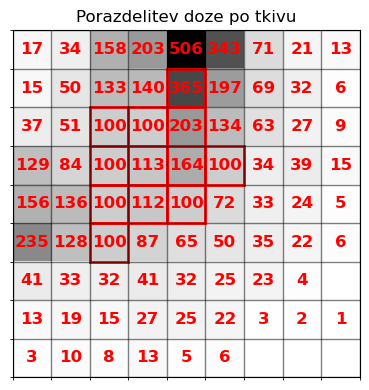

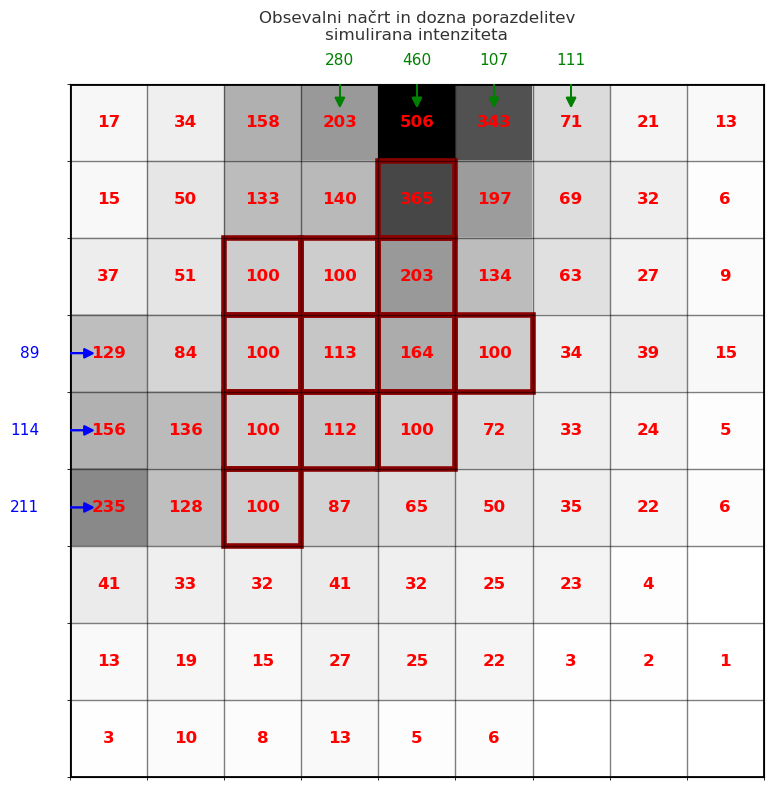

Statistics:
Average dose to tumor cells: 138.20
Average dose to healthy cells: 59.21


In [224]:
optimizer.plot_dose_distribution()
optimizer.plot_irradiation_scheme()
# calculate statistics
optimizer.report_statistics()

----------

Finish

---------------
-----------------
